In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plot

In [2]:
baslik=['KullaniciId','FilmId','Degerlendirme','ZamanDagasi']
df=pd.read_csv('u.data', sep='\t', names=baslik)

In [4]:
KullaniciSayisi=df.KullaniciId.unique().shape[0]
FilmSayisi=df.FilmId.unique().shape[0]
print('Kullanıcı Sayısı =' + str(KullaniciSayisi) + ', Film sayısı =' + str(FilmSayisi))
df.head()

Kullanıcı Sayısı =943, Film sayısı =1682


,KullaniciId,FilmId,Degerlendirme,ZamanDagasi
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


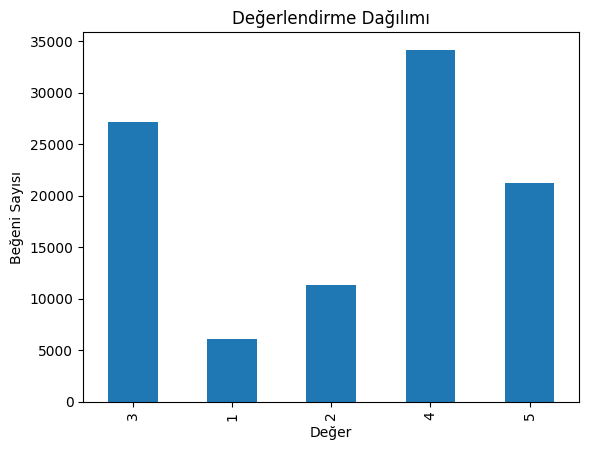

In [5]:
plot.rc("font",size=10)
df.Degerlendirme.value_counts(sort=False).plot(kind='bar')
plot.title("Değerlendirme Dağılımı")
plot.xlabel("Değer")
plot.ylabel("Beğeni Sayısı")
plot.show()

In [11]:
df_ort=pd.DataFrame(round(df.groupby('FilmId')['Degerlendirme'].mean()))
df_ort['DsTemp']=pd.DataFrame(df.groupby('FilmId') ['Degerlendirme'].count())
df_ort.columns=['DegerOrtalamasi', 'DegerSayisi']
df_ort.sort_values('DegerSayisi', ascending=False).head()

,DegerOrtalamasi,DegerSayisi
FilmId,,
50,4.0,583
258,4.0,509
100,4.0,508
181,4.0,507
294,3.0,485


In [12]:
k_u_matris=np.zeros((KullaniciSayisi, FilmSayisi))
for line in df.itertuples():
    k_u_matris[line[1]-1, line[2]-1]=line[3]
k_u_matris.shape

(943, 1682)

In [13]:
from sklearn.metrics.pairwise import pairwise_distances
kullanici_benzerlik=pairwise_distances(k_u_matris, metric='cosine')
kullanici_benzerlik.shape

(943, 943)

In [14]:
def tahmin(degerlendirme,benzerlik):
  ortalama_degerlendirme=degerlendirme.mean(axis=1)
  degerlendirme_farki=(degerlendirme-ortalama_degerlendirme[:,np.newaxis])
  tahmin=ortalama_degerlendirme[:,np.newaxis]+benzerlik.dot(degerlendirme_farki)/np.array([np.abs(benzerlik).sum(axis=1)]).T
  return tahmin
#tahmin fonksiyonun çağrılması
kullanici_tahmin=tahmin(k_u_matris, kullanici_benzerlik)


In [19]:
seyreklik=round(1.0 -len(df)/float(KullaniciSayisi*FilmSayisi),4)
print('Seyreklik = %' + str(seyreklik*100))

Seyreklik = %93.7


In [20]:
import scipy.sparse as sp
from scipy.sparse.linalg import svds
U,S,V=svds(k_u_matris, k=30)
U.shape

(943, 30)

In [21]:
from sklearn.metrics import mean_squared_error
from math import sqrt
def RMSE_Hesapla(tahmin,referans_veri):
  tahmin= tahmin[referans_veri.nonzero()].flatten()
  referans_veri=referans_veri[referans_veri.nonzero()].flatten()
  return sqrt(mean_squared_error(tahmin,referans_veri))

In [25]:
#Test ve Eğitim veri kümesinin ayrıştırılması
from sklearn import model_selection as MS
egitim_veri_kumesi, test_veri_kumesi= MS.train_test_split(df, test_size=0.30)

In [26]:
#Eğitim matrisinin oluşturulması
k_u_matris_egitim=np.zeros((KullaniciSayisi, FilmSayisi))
for line in egitim_veri_kumesi.itertuples():
    k_u_matris_egitim[line[1]-1, line[2]-1]=line[3]

In [27]:
#Test matrisinin oluşturulması
k_u_matris_test=np.zeros((KullaniciSayisi, FilmSayisi))
for line in test_veri_kumesi.itertuples():
    k_u_matris_test[line[1]-1, line[2]-1]=line[3]

In [28]:
#Kullanıcı arasındaki benzerliklerin hesaplanması
from sklearn.metrics.pairwise import pairwise_distances
kullanici_benzerlik=pairwise_distances(k_u_matris_egitim, metric='cosine')

In [29]:
#Tahmin fonksiyonu çağrılması
kullanici_tahmin=tahmin(k_u_matris_egitim, kullanici_benzerlik)
print('Orjinal RMSE: ' + str(RMSE_Hesapla(kullanici_tahmin,k_u_matris_test)))


Orjinal RMSE: 3.15902701225606


In [30]:
#SVD Hesaplama
from scipy.sparse.linalg import svds
U,S,Vt=svds(k_u_matris_egitim, k=30)

In [31]:
S_Diyag_Matrisi=np.diag(S)
SVD_tahmin=np.dot(np.dot(U,S_Diyag_Matrisi),Vt)
print('SVD RMSE: ' + str(RMSE_Hesapla(SVD_tahmin,k_u_matris_test)))

SVD RMSE: 2.8730259345398177
